# Zotec Assessment

## Task
Nutrition.csv contains somewhat incomplete records of the nutritional information of 8,790 foods, including the number of calories in each food represented by the field “Energ_Kcal”.

In this hypothetical scenario, the General Mills advertising team has the nutritional information of some test foods they plan to bring to market soon, but their scientists have not had a chance to test
each products’ calories. They need you to build a model that can estimate the number of calories in a food based on the nutritional information in the dataset, so that they can get a head start on their
marketing material rather than having to wait for the scientists testing which will take 3 months to perform.

Using your preferred programming language (preferably Python or R), please produce a script that builds a predictive model for the number of calories in a food. There is no time limit, but we would expect
this exercise to only take 2-3 hours. Please let me know when you are complete and we will schedule a Zoom meeting for you to present your findings.

## Table of Contents
* Pre-Processing
* Initial XGBoost Regression Model
* Feature Importance (Initial Model)
* Feature Selection
* Feature Engineering
* Truly Dealing with Nulls
* Tuning Hyperparameters and Optimization
    * Finding Optimal Number of Epochs
    * Finding Optimal Number of Features
    * Tuning Params Setup
    * Tuning Learning Rate
    * Tuning 1
    * Tuning 2
    * Tuning 3
    * Tuning 4
* Final Train and Test (With Metrics)
* Feature Importance (Final Model)


# Pre-Processing

In [1]:
# Import initial packages
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Read csv file into dataframe and print first 5 rows
df = pd.read_csv('NutritionData.csv', encoding_errors='ignore')
df.head()

,NDB_No,Shrt_Desc,Water,Energ_Kcal,Protein,Lipid_Tot,Ash,Carbohydrt,Fiber_TD,Sugar_Tot,...,Vit_D_IU,Vit_K,FA_Sat,FA_Mono,FA_Poly,Cholestrl,GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2
0,1001,"BUTTER,WITH SALT",15.87 g,717,0.85,81.11,2.11,0.06,0.0,0.06,...,0.0,7.0,51.368,21.021,3.043,215.0,5.00,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp
1,1002,"BUTTER,WHIPPED,W/ SALT",16.72 g,718,0.49,78.30,1.62,2.87,0.0,0.06,...,0.0,4.6,45.390,19.874,3.331,225.0,3.80,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp
2,1003,"BUTTER OIL,ANHYDROUS",0.24 g,876,0.28,99.48,0.00,0.00,0.0,0.00,...,0.0,8.6,61.924,28.732,3.694,256.0,12.80,1 tbsp,205.0,1 cup
3,1004,"CHEESE,BLUE",42.41 g,353,21.40,28.74,5.11,2.34,0.0,0.50,...,21.0,2.4,18.669,7.778,0.800,75.0,28.35,1 oz,17.0,1 cubic inch
4,1005,"CHEESE,BRICK",41.11 g,371,23.24,29.68,3.18,2.79,0.0,0.51,...,22.0,2.5,18.764,8.598,0.784,94.0,132.00,"1 cup, diced",113.0,"1 cup, shredded"


In [3]:
# Print number of null vales for each column
df.isnull().sum()

NDB_No            0
Shrt_Desc         0
Water             0
Energ_Kcal        0
Protein           0
Lipid_Tot         0
Ash             325
Carbohydrt        0
Fiber_TD        594
Sugar_Tot      1832
Calcium         348
Iron            144
Magnesium       739
Phosphorus      579
Potassium       426
Sodium           83
Zinc            706
Copper         1257
Manganese      2160
Selenium       1700
Vit_C           818
Thiamin         634
Riboflavin      616
Niacin          637
Panto_Acid     2242
Vit_B6          905
Folate_Tot     1261
Folic_Acid     2039
Food_Folate    1768
Folate_DFE     2057
Choline_Tot    4016
Vit_B12        1193
Vit_A_IU        711
Vit_A_RAE      1535
Retinol        1806
Alpha_Carot    3258
Beta_Carot     3162
Beta_Crypt     3270
Lycopene       3292
Lut+Zea        3315
Vit_E          2889
Vit_D          3262
Vit_D_IU       3211
Vit_K          3563
FA_Sat          349
FA_Mono         666
FA_Poly         665
Cholestrl       410
GmWt_1          300
GmWt_Desc1      299


In [4]:
# Find data types of each column
df.dtypes

NDB_No           int64
Shrt_Desc       object
Water           object
Energ_Kcal       int64
Protein        float64
Lipid_Tot      float64
Ash            float64
Carbohydrt     float64
Fiber_TD       float64
Sugar_Tot      float64
Calcium        float64
Iron           float64
Magnesium      float64
Phosphorus     float64
Potassium      float64
Sodium         float64
Zinc           float64
Copper         float64
Manganese      float64
Selenium       float64
Vit_C          float64
Thiamin        float64
Riboflavin     float64
Niacin         float64
Panto_Acid     float64
Vit_B6         float64
Folate_Tot     float64
Folic_Acid     float64
Food_Folate    float64
Folate_DFE     float64
Choline_Tot    float64
Vit_B12        float64
Vit_A_IU       float64
Vit_A_RAE      float64
Retinol        float64
Alpha_Carot    float64
Beta_Carot     float64
Beta_Crypt     float64
Lycopene       float64
Lut+Zea        float64
Vit_E          float64
Vit_D          float64
Vit_D_IU       float64
Vit_K      

In [5]:
# This list is for the initial regression model. Excludes string (object) columns
columns_chosen = []

# Get column names that have data type int or float
for col in df:
    if df[col].dtype in ['int64', 'float64']:
        columns_chosen.append(col)
    else:
        pass

In [6]:
pd.set_option('mode.chained_assignment',None)

# Obtain dataframe based on columns chosen above
df_chosen = df[columns_chosen]

# Initially just fill null values with 0
for col in df_chosen:
    df_chosen[col] = df_chosen[col].fillna(0)

In [7]:
# Get updated list of null values in each column. Should be 0 in all
df_chosen.isnull().sum()

NDB_No         0
Energ_Kcal     0
Protein        0
Lipid_Tot      0
Ash            0
Carbohydrt     0
Fiber_TD       0
Sugar_Tot      0
Calcium        0
Iron           0
Magnesium      0
Phosphorus     0
Potassium      0
Sodium         0
Zinc           0
Copper         0
Manganese      0
Selenium       0
Vit_C          0
Thiamin        0
Riboflavin     0
Niacin         0
Panto_Acid     0
Vit_B6         0
Folate_Tot     0
Folic_Acid     0
Food_Folate    0
Folate_DFE     0
Choline_Tot    0
Vit_B12        0
Vit_A_IU       0
Vit_A_RAE      0
Retinol        0
Alpha_Carot    0
Beta_Carot     0
Beta_Crypt     0
Lycopene       0
Lut+Zea        0
Vit_E          0
Vit_D          0
Vit_D_IU       0
Vit_K          0
FA_Sat         0
FA_Mono        0
FA_Poly        0
Cholestrl      0
GmWt_1         0
GmWt_2         0
dtype: int64

In [8]:
# Drop prediction nd ID column as input data
df_chosen_x = df_chosen.drop(labels=['Energ_Kcal', 'NDB_No'], axis=1)

# Kcal as prediction column
df_chosen_y = df_chosen['Energ_Kcal']

# Initial XGBoost Regression Model (Only Null Values Changed)

In [9]:
# Import packages for regression
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [10]:
from sklearn import preprocessing

# Prepare data for mode
def prepareData(x_data, y_data):
    x = x_data.values

    y = pd.DataFrame(y_data)
    y = y.values
    return x, y

[X, y] = prepareData(df_chosen_x, df_chosen_y)

In [11]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Create regression object
model = xgb.XGBRegressor()

In [12]:
# Fit model with train data and output RMSE validation at each epoch
model.fit(X_train, y_train, eval_set=[(X_train, y_train)])

[0]	validation_0-rmse:199.16707
[1]	validation_0-rmse:141.06759
[2]	validation_0-rmse:100.24550
[3]	validation_0-rmse:71.75613
[4]	validation_0-rmse:51.99379
[5]	validation_0-rmse:38.42364
[6]	validation_0-rmse:28.85692
[7]	validation_0-rmse:22.32591
[8]	validation_0-rmse:17.90768
[9]	validation_0-rmse:15.14564
[10]	validation_0-rmse:13.17146
[11]	validation_0-rmse:11.94791
[12]	validation_0-rmse:11.02854
[13]	validation_0-rmse:10.36547
[14]	validation_0-rmse:9.83065
[15]	validation_0-rmse:9.52378
[16]	validation_0-rmse:8.98272
[17]	validation_0-rmse:8.85166
[18]	validation_0-rmse:8.58288
[19]	validation_0-rmse:8.41767
[20]	validation_0-rmse:8.21325
[21]	validation_0-rmse:8.00720
[22]	validation_0-rmse:7.97154
[23]	validation_0-rmse:7.86185
[24]	validation_0-rmse:7.79542
[25]	validation_0-rmse:7.67217
[26]	validation_0-rmse:7.44513
[27]	validation_0-rmse:7.29430
[28]	validation_0-rmse:7.17318
[29]	validation_0-rmse:7.07893
[30]	validation_0-rmse:7.01011
[31]	validation_0-rmse:6.83418
[

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [13]:
# Import metric scores
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

# Make Prediction with test data
yhat = model.predict(X_test)

# Get three most common score metrics for regression
MSE = mean_squared_error(y_test, yhat)
RMSE = math.sqrt(MSE)
R2 = r2_score(y_test, yhat)

# Print Scores
print("Mean Square Error: {}\nRoot Mean Square Error: {}\nR Squared: {}".format(MSE, RMSE,R2))

Mean Square Error: 153.38228288024627
Root Mean Square Error: 12.384760105881998
R Squared: 0.9946627141834498


# Feature Importance (Initial Model)

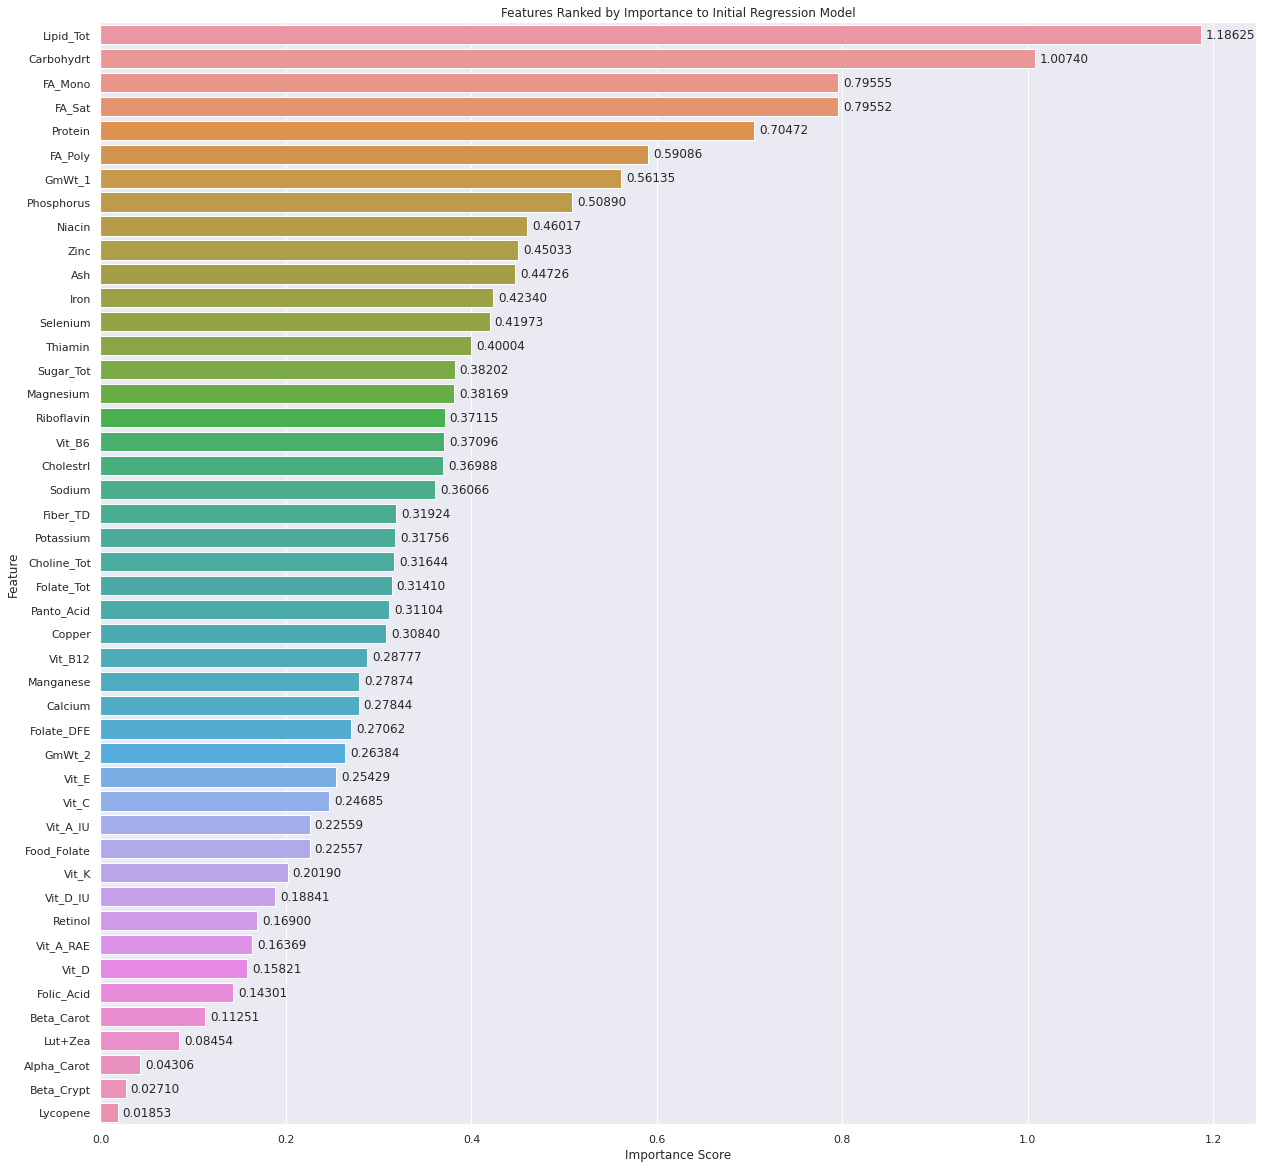

In [15]:
# Import packages for feature importance
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Get labels for chosen columns (same as columns_chosen)
labels = [col for col in df_chosen_x]

# Get importance scores for features used in initial model (Not used)
importance = list(model.feature_importances_)

# Ravel train data
y_train = np.ravel(y_train)

# Use mutual information for feature importance
fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(X_train, y_train)

# Put importance scores into dataframe and order
df_importance = pd.DataFrame({'labels': labels, 'importance': fs.scores_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=False)

# Graph feature importances by feature
ax=sns.barplot(x='importance', y='labels', data=df_importance_sorted, orient='h')
ax.bar_label(container=ax.containers[0], fmt='%1.5f', label_type='edge', padding=5)
sns.set(rc={'figure.figsize':(20.7, 20.27)})
plt.title('Features Ranked by Importance to Initial Regression Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Feature Selection via Correlation

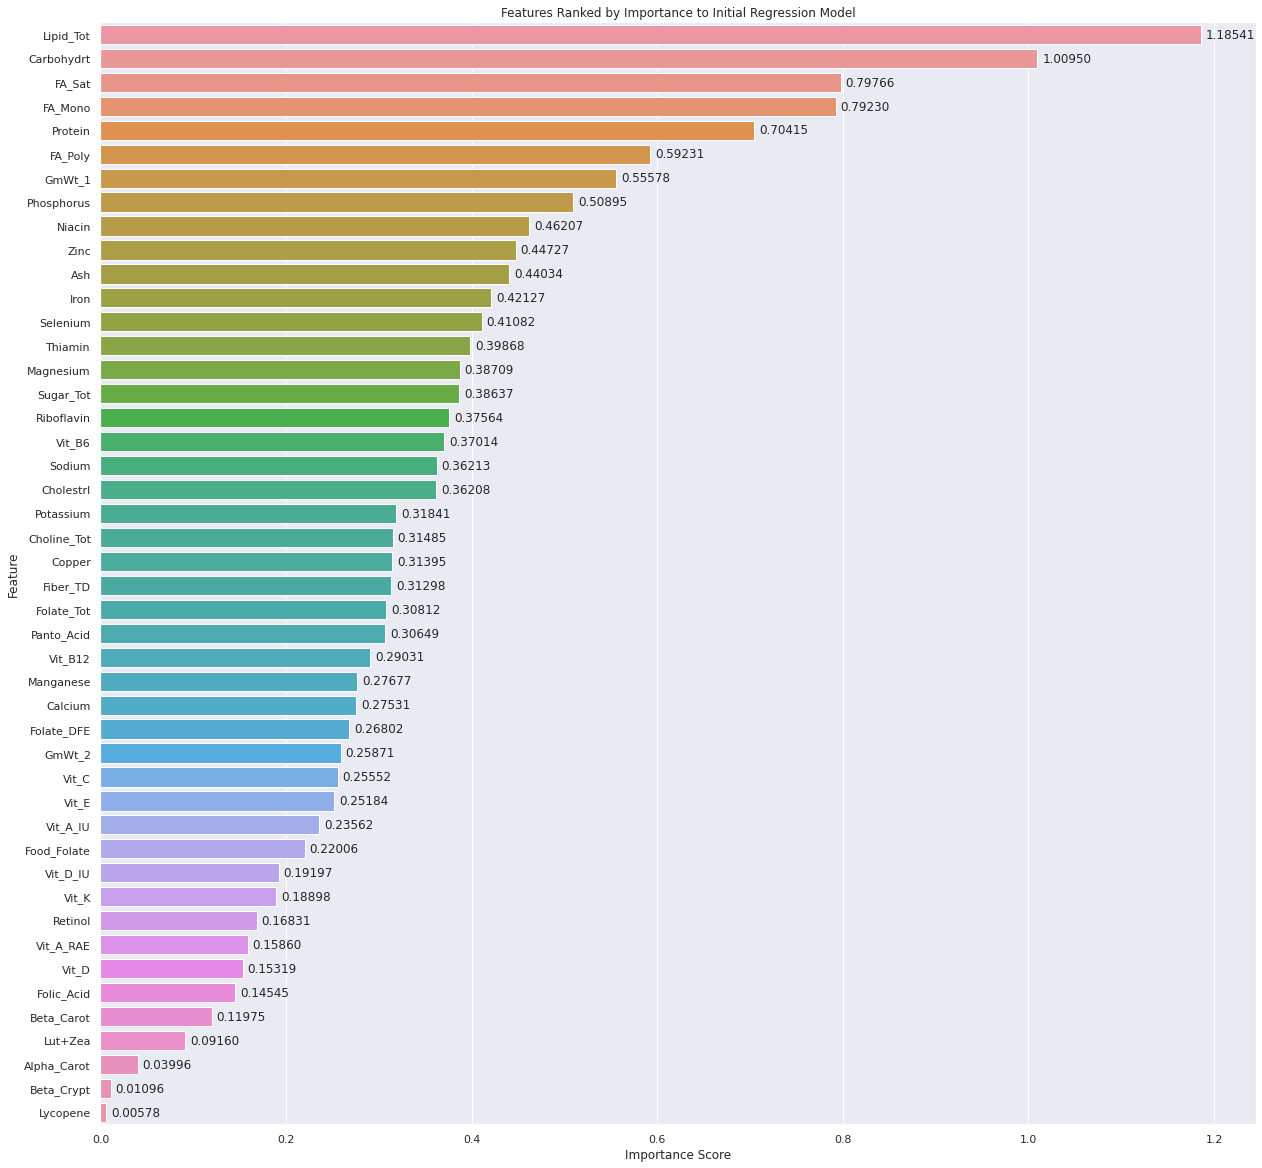

In [16]:
# Import packages for feature importance
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Get labels for chosen columns (same as columns_chosen)
labels = [col for col in df_chosen_x]

# Get importance scores for features used in initial model (Not used)
importance = list(model.feature_importances_)

# Ravel train data
y_train = np.ravel(y_train)

# Use mutual information for feature importance
fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(X_train, y_train)

# Put importance scores into dataframe and order
df_importance = pd.DataFrame({'labels': labels, 'importance': fs.scores_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=False)

# Graph feature importances by feature
ax=sns.barplot(x='importance', y='labels', data=df_importance_sorted, orient='h')
ax.bar_label(container=ax.containers[0], fmt='%1.5f', label_type='edge', padding=5)
sns.set(rc={'figure.figsize':(20.7, 20.27)})
plt.title('Features Ranked by Importance to Initial Regression Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Feature Selection via Correlation

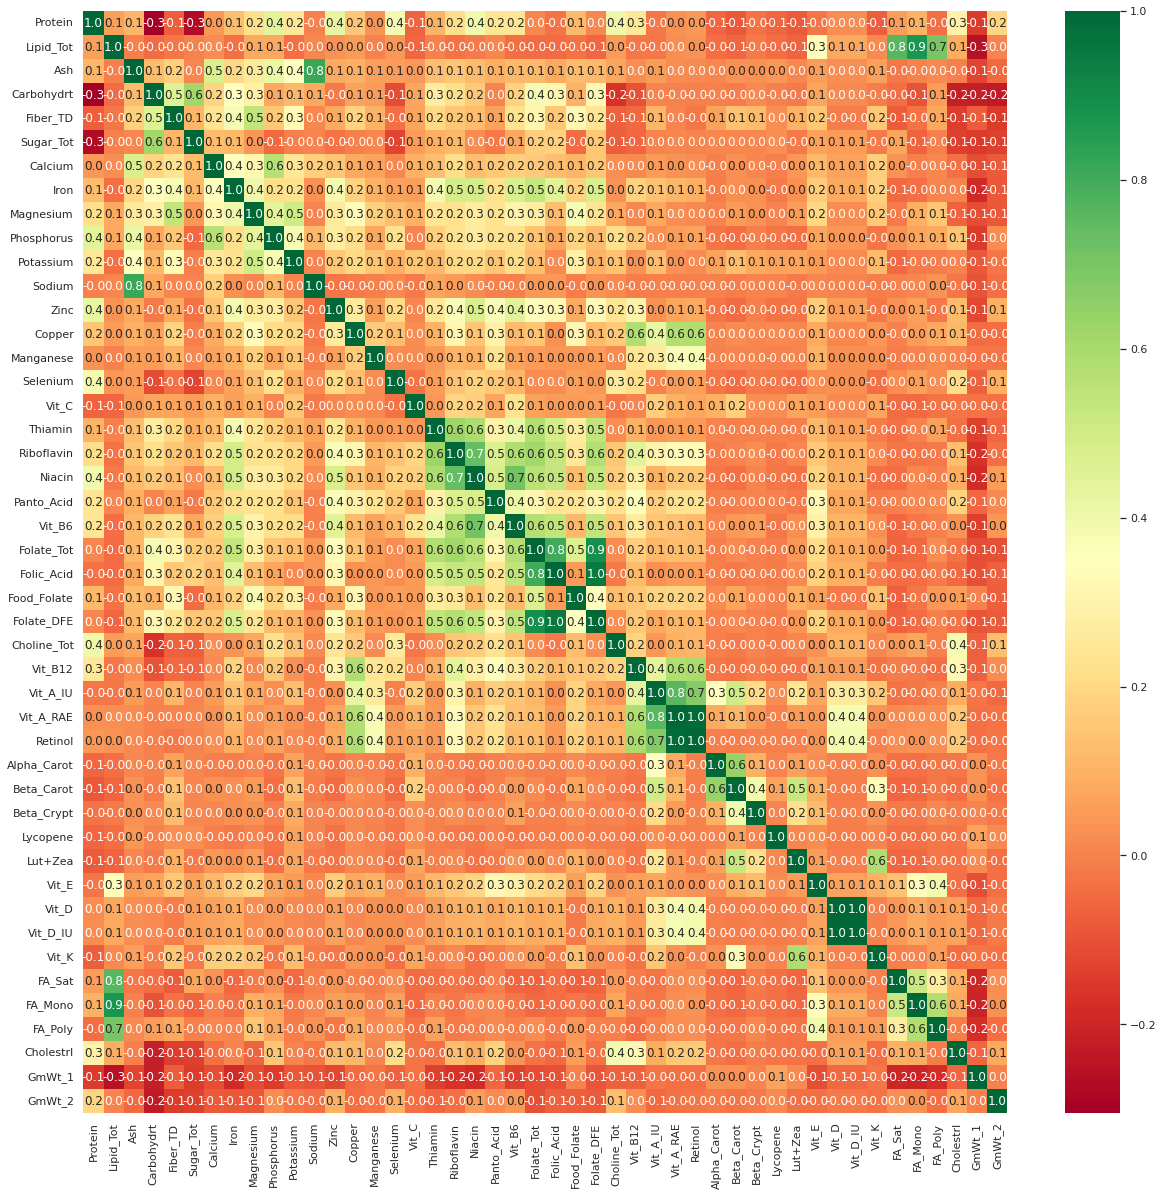

In [17]:
# Create original correlation matrix for numerical data dataframe (Categorical data wouldn't be on here anyways)
corr_original = df_chosen_x.corr().abs()

# Graph heatmap of original correlation matrix
ax=sns.heatmap(df_chosen[corr_original.index].corr(),annot=True,cmap='RdYlGn', fmt='1.1f')

In [18]:
# https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python

# Find columns to drop based on having a similar correlation (More than 0.7)
# In this case only 1 column of the two highly correlated columns is kept
upper_tri = corr_original.where(np.triu(np.ones(corr_original.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.70)]

# Drop columns
df_chosen_x = df_chosen_x.drop(labels=to_drop, axis=1)

/tmp/ipykernel_72509/766412788.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr_original.where(np.triu(np.ones(corr_original.shape),k=1).astype(np.bool))


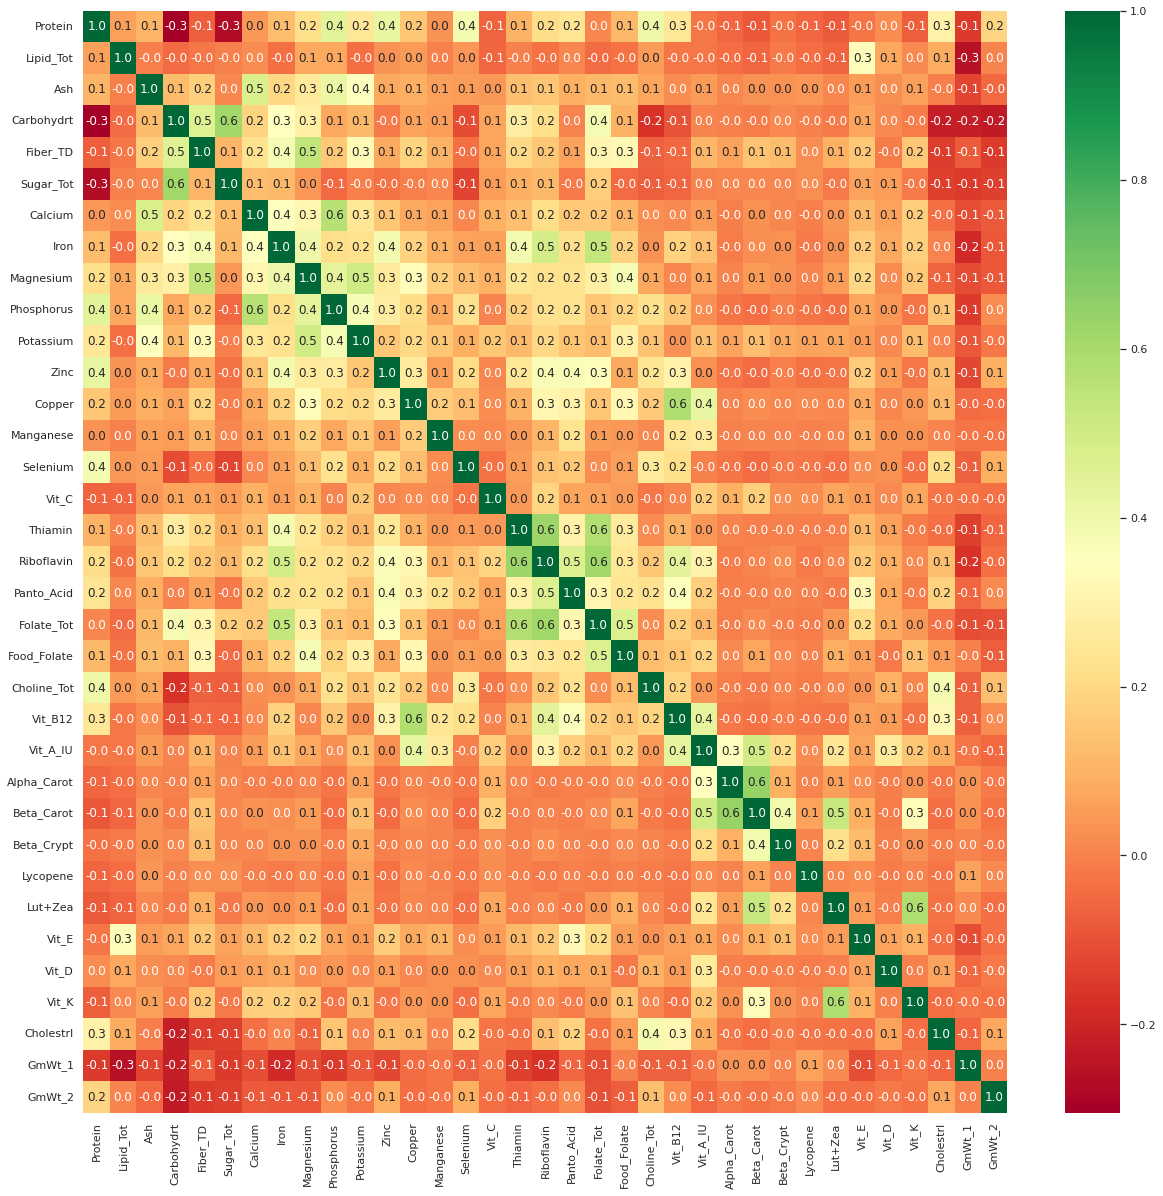

In [19]:
# Graph final correlation matrix which represents all numerical columns to use for final model
corr_final = df_chosen_x.corr().abs()
ax=sns.heatmap(df_chosen[corr_final.index].corr(),annot=True,cmap='RdYlGn', fmt='1.1f')

# Feature Engineering

In [20]:
# Split description to use first part. Essentially the Category
split_desc = df['Shrt_Desc'].str.split(',')

category = []
for split in split_desc:
    category.append(split[0])

In [21]:
# Get database for engineering step while taking into account feature selection phase
df_eng = df.drop(labels=to_drop, axis=1)

In [22]:
# change desc_cat to category values (first part)
df_eng['Desc_Cat'] = category
df_eng['Desc_Cat'] = df_eng['Desc_Cat'].astype("category")
df_eng['Desc_Cat']

0           BUTTER
1           BUTTER
2       BUTTER OIL
3           CHEESE
4           CHEESE
           ...    
8785      MACKEREL
8786       SCALLOP
8787         SYRUP
8788         SNAIL
8789        TURTLE
Name: Desc_Cat, Length: 8790, dtype: category
Categories (1392, object): ['ABALONE', 'ABIYUCH', 'ACEROLA', 'ACEROLA JUICE', ..., 'YOGURT', 'YOGURT PARFAIT', 'YOKAN', 'ZWIEBACK']

In [23]:
# Get rid grams (g) in water column
split_water = df_eng['Water'].str.split(' ')

water_g = []
for split in split_water:
    water_g.append(split[0])

# Fix the anomaly in water column
water_g[1941]
df_eng['Water_Flt'] = water_g

df_eng = df_eng[df_eng['NDB_No']!=8370]

df_eng['Water_Flt'] = df_eng['Water_Flt'].astype('float')

# Truly Dealing with Null Data

In [24]:
# Drop other categorical columns not to use. Based on my discretion
df_eng = df_eng.drop(labels=['NDB_No', 'Shrt_Desc', 'Water', 'GmWt_Desc1', 'GmWt_1', 'GmWt_Desc2', 'GmWt_2'], axis=1)

In [25]:
# Only get columns who have more than 2000 null values for prediction
df_eng_null = df_eng.isnull().sum()
high_null_list = df_eng_null[df_eng.isnull().sum()>2000].index

In [26]:
col = []
zeros = []

# For columns with more than 2000 null values, get count of zeros in column
for column in high_null_list:
    try:
        zeros_count = df_eng[column].value_counts().loc[0.0]
        zeros.append(zeros_count)
        col.append(column)
    except:
        pass

df_zeros_high = pd.DataFrame({'zero_count':zeros}, index=col)

In [27]:
# Get dataframe with more than 1000 zeros and more than 2000 null values
high_zeros_df = df_zeros_high[df_zeros_high['zero_count']>1000].index

In [28]:
# Fill high_zeros_df columns with zeros
for col in high_zeros_df:
    df_eng[col] = df_eng[col].fillna(0)

In [29]:
df_null_fill = df_eng
df_null_fill = df_null_fill.drop(labels='Desc_Cat', axis=1)
df_null_update = df_null_fill.isnull().sum()
df_null_columns = df_null_update[df_null_update>0].index
df_null_fill = df_null_fill.dropna(axis=0)

In [30]:
df_null_columns

Index(['Ash', 'Fiber_TD', 'Sugar_Tot', 'Calcium', 'Iron', 'Magnesium',
       'Phosphorus', 'Potassium', 'Zinc', 'Copper', 'Manganese', 'Selenium',
       'Vit_C', 'Thiamin', 'Riboflavin', 'Panto_Acid', 'Folate_Tot',
       'Food_Folate', 'Choline_Tot', 'Vit_B12', 'Vit_A_IU', 'Vit_E',
       'Cholestrl'],
      dtype='object')

In [31]:
df_prep = df_eng

# Idea behind this is to predict values that are null based on other columns. For all original null values not changed to 0
for col in df_null_columns:
    df_null_fill[col] = df_null_fill[col].replace('None', pd.NA)
    df_x = df_null_fill.drop(labels=col, axis=1)
    df_y = df_null_fill[col]
    [X, y] = prepareData(df_x, df_y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    model_na = xgb.XGBRegressor()
    model_na.fit(X_train, y_train)

    indices = df_eng[df_eng[col].isnull()].index
    df_predict = df_eng[df_eng[col].isnull()]
    X_predict = df_predict.drop(labels=[col, 'Desc_Cat'], axis=1).fillna(0).values
    predicted = model_na.predict(X_predict)
    # Negative predicted values changed to 0, values larger than the original maximum changed to original maximum
    for x, y in zip(indices, predicted):
        if (y > 0) and (y < df_eng[col].max()):
            df_prep.loc[x, col] = round(y, 2)
        elif y < 0:
            df_prep.loc[x, col] = 0
        else:
            df_prep.loc[x, col] = round(df_eng[col].max(), 2)

In [32]:
# Round all values to 2 decimal places
for col in df_prep:
    try:
        df_prep[col] = df_prep[col].round(2)
    except:
        pass

In [33]:
# Re split data into independent variables and prediction column
df_prep_x = df_prep.drop(labels='Energ_Kcal', axis=1)
df_prep_y = df_prep['Energ_Kcal']

# Tuning Hyperparameters and Optimization

### Finding Optimal Number of Epochs

In [34]:
# https://practicaldatascience.co.uk/machine-learning/how-to-avoid-model-overfitting-with-early-stopping-rounds

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(df_prep_x, df_prep_y, test_size=0.3, random_state=0)

In [35]:
# Create original regressor model to find optimal stopping point
model = xgb.XGBRegressor(enable_categorical=True, tree_method='hist', objective='reg:squarederror', eval_metric='logloss', n_estimators=100)

# Define eval set and train data
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train,
          y_train,
          eval_set=eval_set,
          verbose=False)
results = model.evals_result()
test_scores = results['validation_1']['logloss']
best_test = min(test_scores)
print("Best Test Score: {}".format(best_test))

Best Test Score: -9587.886073708427


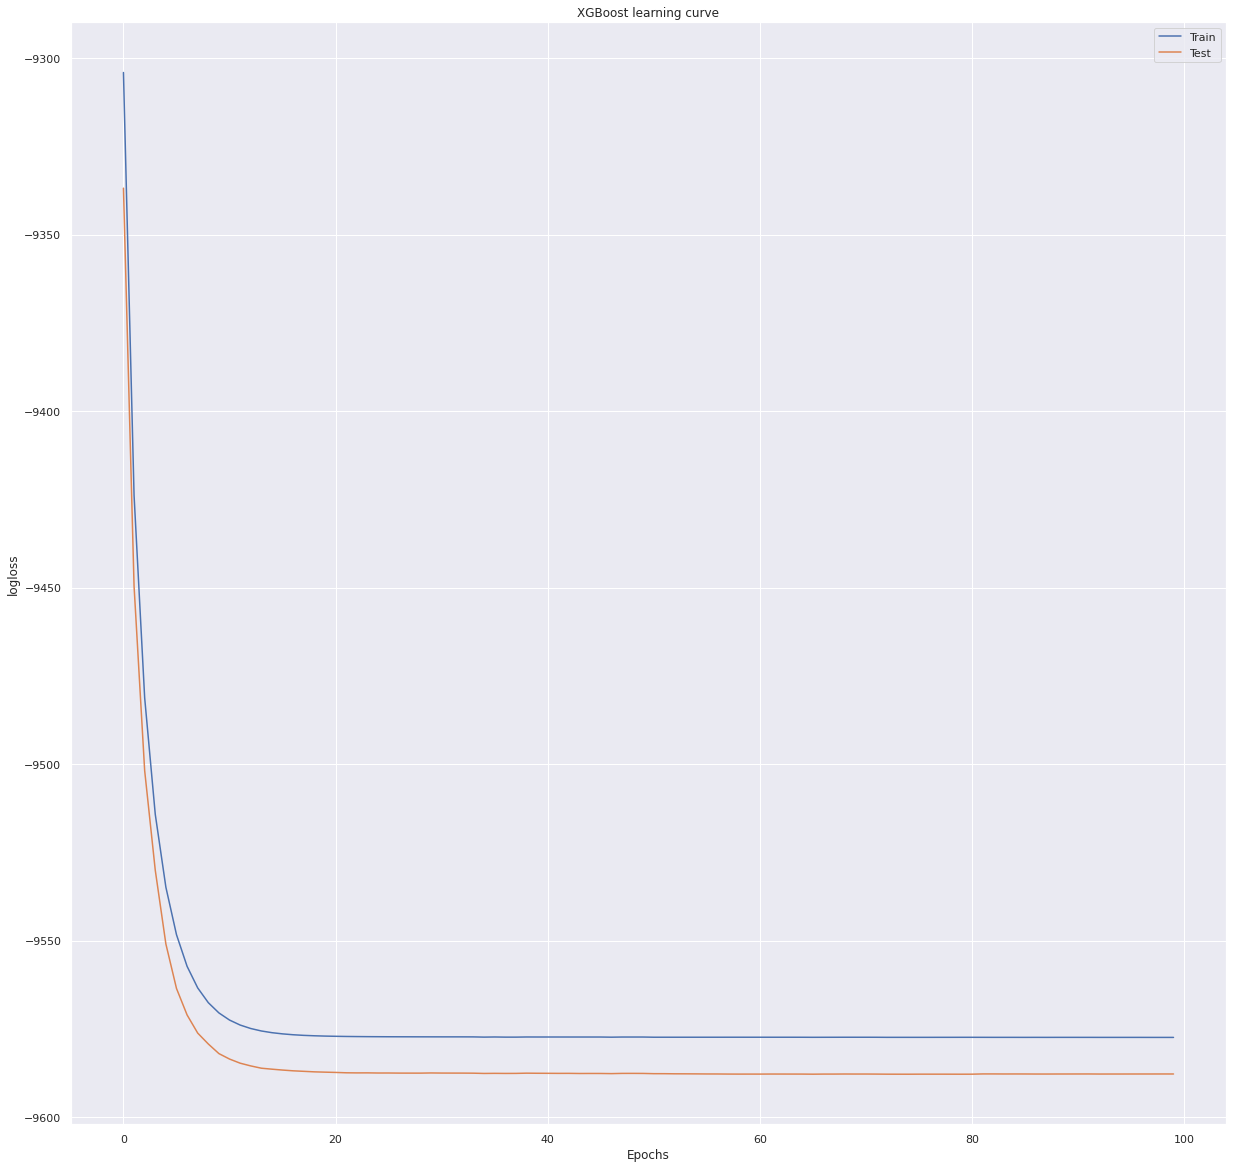

In [36]:
# Graph epochs versus change of logloss score.
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('logloss')
plt.title('XGBoost learning curve')
plt.show()

Decrease in negative log loss slows down around 10 and flattens around 15-20. I will set n_estimators to 15 to avoid overfitting

### Finding Optimal Number of Features

In [37]:
from sklearn import preprocessing

X_train_encoded = X_train.copy()

# Get labels for chosen columns (same as columns_chosen)
labels = [col for col in X_train]

LE = preprocessing.LabelEncoder()

X_train_encoded['Desc_Cat'] = LE.fit_transform(X_train_encoded['Desc_Cat'])

# Ravel train data
y_train_ravel = np.ravel(y_train)

# Use mutual information for feature importance
fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(X_train_encoded, y_train_ravel)

# Put importance scores into dataframe and order
df_importance = pd.DataFrame({'labels': labels, 'importance': fs.scores_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=False)

In [38]:
columns_ordered = df_importance_sorted['labels'].values
model_feat = xgb.XGBRegressor(enable_categorical=True, tree_method='hist', objective='reg:squarederror', eval_metric='rmse', n_estimators=15, n_jobs=-1)

features_list = []
mse_test_list = []
mse_train_list = []

for i in range(5, len(columns_ordered)+1):
    columns_chosen = columns_ordered[0:i]

    model_feat.fit(X_train[columns_chosen],
          y_train,
          verbose=False)
    yhat_test = model_feat.predict(X_test[columns_chosen])
    yhat_train = model_feat.predict(X_train[columns_chosen])

    mse_test = mean_squared_error(y_test, yhat_test)
    mse_train = mean_squared_error(y_train, yhat_train)
    features_list.append(i)
    mse_test_list.append(mse_test)
    mse_train_list.append(mse_train)

best_score = min(mse_test_list)
best_index = mse_test_list.index(best_score)
best_features = features_list[best_index]
print("Best Number of Features: {}".format(best_features))

Best Number of Features: 15


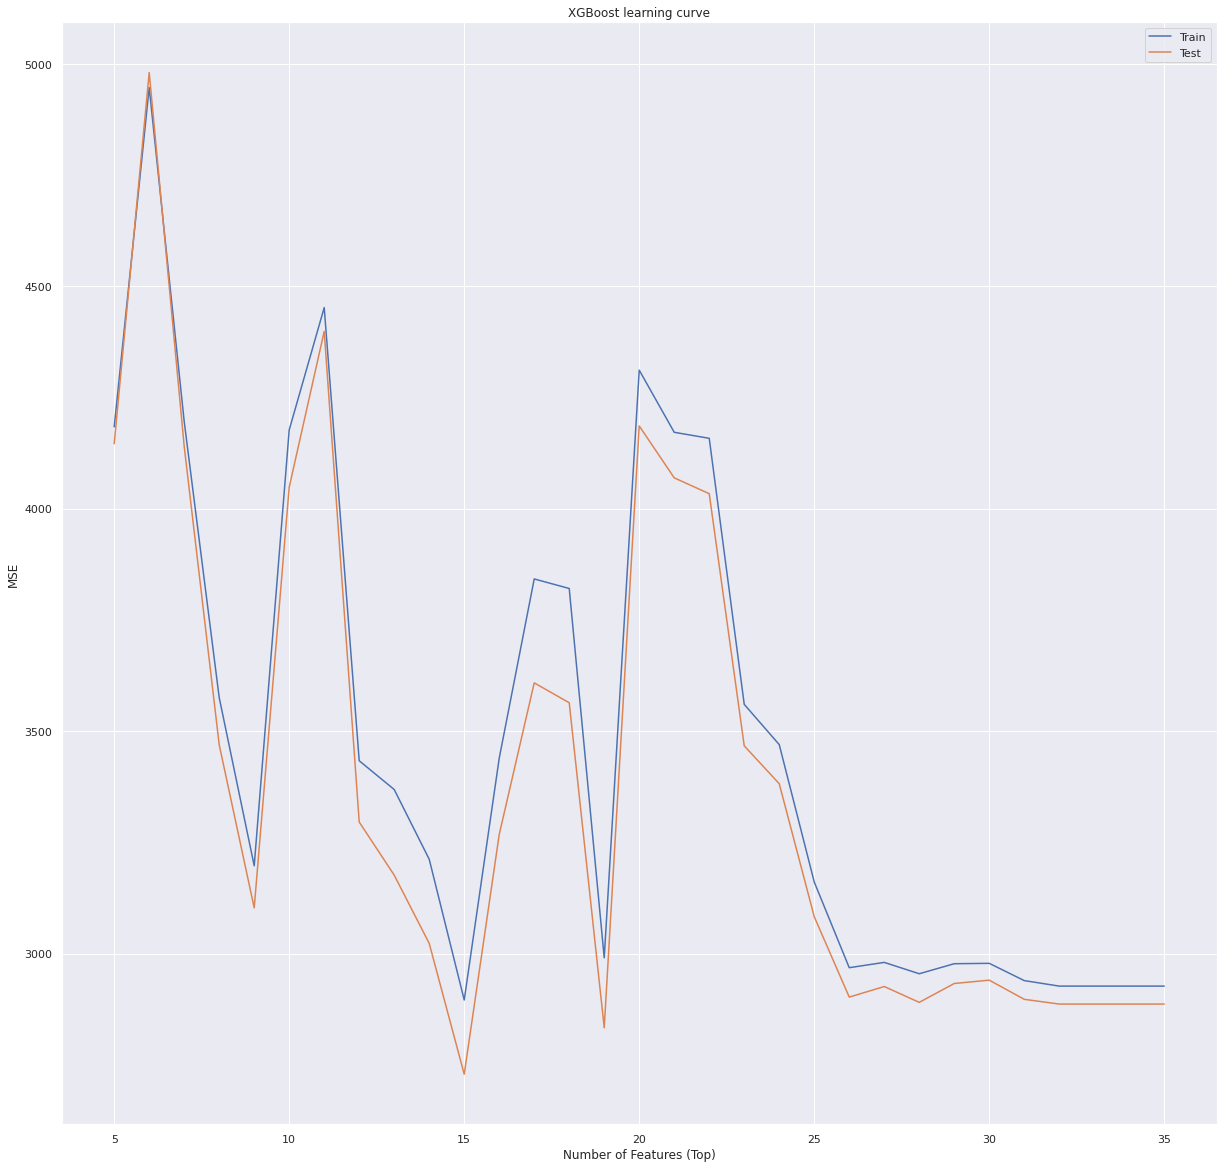

In [39]:
fig, ax = plt.subplots()
ax.plot(features_list, mse_train_list, label='Train')
ax.plot(features_list, mse_test_list, label='Test')
ax.legend()
plt.xlabel('Number of Features (Top)')
plt.ylabel('MSE')
plt.title('XGBoost learning curve')
plt.show()

15 features yields the best mse score so 15 features will be chosen. Disadvantages of this method will be discussed in conclusion.

In [40]:
# Get Data
columns_chosen = columns_ordered[0:15]

X_train = X_train[list(columns_chosen)]
X_test = X_test[list(columns_chosen)]

### Tuning Params Setup

In [41]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Create object that tunes parameters for any model
class tuneHyperParams(object):

    def __init__(self, model, scoring):
        self.model = model
        self.scoring = scoring

    # Obtain the best k for stratified k folds validation
    def obtainBestKFolds(self, X_train, y_train, val_range):
        df_scores = pd.DataFrame(columns=['kfolds', self.scoring])
        for k in val_range:
            cv = StratifiedKFold(n_splits=k, random_state=0, shuffle=True)
            score = cross_validate(self.model, X_train, y_train, scoring=self.scoring, cv=cv, n_jobs=-1)
            score_mean = score['test_score'].mean()
            df_scores = pd.concat([df_scores, pd.DataFrame.from_records([{'kfolds':int(k), '{}'.format(self.scoring):score_mean}])], ignore_index=True)
        best_value_list = list(df_scores[self.scoring].values)
        k_values_list = list(df_scores['kfolds'].values)
        best_value = max(best_value_list)
        best_index = best_value_list.index(best_value)
        kfolds_best = k_values_list[best_index]
        return kfolds_best

    # Tune model using specified k folds and params via grid search
    def tuneModel(self, X, y, kfolds, params_grid):
        cv = StratifiedKFold(n_splits=kfolds, random_state=0, shuffle=True)
        gsearch = GridSearchCV(estimator=self.model,
                                param_grid = params_grid, scoring=self.scoring,n_jobs=-1, cv=cv)
        grid_result = gsearch.fit(X, y)
        return grid_result

In [42]:
# Define function that creates tuning class for XGBoost
def tuneXGBoost(set_params, params_grid, first_time=True, best_k=None):
    model = xgb.XGBRegressor(enable_categorical=True, tree_method='hist', objective='reg:squarederror', eval_metric='logloss', n_estimators=15, n_jobs=-1)
    model.set_params(**set_params)

    XGB = tuneHyperParams(model, 'neg_root_mean_squared_error')

    if first_time is True:
        best_k = XGB.obtainBestKFolds(X_train, y_train, range(2, 21))
        grid_result = XGB.tuneModel(X_train, y_train, best_k, params_grid)
        return grid_result, best_k

    elif first_time is False:
        grid_result = XGB.tuneModel(X_train, y_train, best_k, params_grid)
        return grid_result

    else:
        grid_result = None
        return grid_result

In [43]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
# To merge parameters set
def mergeDict(original, addition):
    return(original.update(addition))

### Tuning Learning Rate

In [45]:
params_test = {
    'learning_rate': [i/100 for i in range(1, 40, 2)]
}

# Create initial param set
params_set = {}

[grid_result, best_k] = tuneXGBoost(params_set, params_test)

In [46]:
best_params = grid_result.best_params_
mergeDict(params_set, best_params)

print(best_params)
print(grid_result.best_score_)
print(best_k)

{'learning_rate': 0.27}
-58.028115752806414
4


### Tuning 1

In [47]:
params_test1 = {
    'max_depth': range(2, 21, 1),
    'min_child_weight': range(2, 31, 2)
}

grid_result1 = tuneXGBoost(params_set, params_test1, first_time=False, best_k=best_k)

In [48]:
best_params1 = grid_result1.best_params_
mergeDict(params_set, best_params1)

print(best_params1)
print(grid_result1.best_score_)

{'max_depth': 8, 'min_child_weight': 14}
-15.31753596793804


### Tuning 2

In [49]:
params_test2 = {
    'gamma': range(1,50,2)
}

grid_result2 = tuneXGBoost(params_set, params_test2, first_time=False, best_k=best_k)

In [50]:
best_params2 = grid_result2.best_params_
mergeDict(params_set, best_params2)

print(best_params2)
print(grid_result2.best_score_)

{'gamma': 5}
-15.248902747986905


### Tunning 3

In [51]:
params_test3 = {
    'subsample': [i/10 for i in range(4, 11, 1)],
    'colsample_bytree': [i/10 for i in range(6, 11, 1)]
}

grid_result3 = tuneXGBoost(params_set, params_test3, first_time=False, best_k=best_k)

In [52]:
best_params3 = grid_result3.best_params_
mergeDict(params_set, best_params3)

print(best_params3)
print(grid_result3.best_score_)

{'colsample_bytree': 1.0, 'subsample': 1.0}
-15.248902747986905


### Tunning 4

In [53]:
params_test4 = {
    'reg_alpha': [0, .01, .02, .03, .04],
    'max_bin': range(500, 2000, 100)
}

grid_result4 = tuneXGBoost(params_set, params_test4, first_time=False, best_k=best_k)

In [54]:
best_params4 = grid_result4.best_params_
mergeDict(params_set, best_params4)

print(best_params4)
print(grid_result4.best_score_)

{'max_bin': 1400, 'reg_alpha': 0.03}
-13.787508478068677


In [55]:
params_set

{'learning_rate': 0.27,
 'max_depth': 8,
 'min_child_weight': 14,
 'gamma': 5,
 'colsample_bytree': 1.0,
 'subsample': 1.0,
 'max_bin': 1400,
 'reg_alpha': 0.03}

# Final Train and Test

In [56]:
# Final Train with all tuned parameters
XGB_F = xgb.XGBRegressor(enable_categorical=True, tree_method='hist', objective='reg:squarederror', eval_metric='logloss', n_estimators=15, n_jobs=-1)
XGB_F.set_params(**params_set)
XGB_F.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric='logloss', gamma=5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.27, max_bin=1400, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=14,
             missing=nan, monotone_constraints='()', n_estimators=15, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.03, reg_lambda=1, ...)

In [57]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import d2_absolute_error_score
from sklearn.metrics import explained_variance_score

# Final prediction
yhat = XGB_F.predict(X_test)

# Create final metrics
r2 = r2_score(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
d2 = d2_absolute_error_score(y_test, yhat)
evs = explained_variance_score(y_test, yhat)

# Print final metrics
print("R Squared: {}\nMean Squared Error: {}\nD Squared: {}\nExplained Variance: {}".format(round(r2,5), round(mse,2), round(d2,5), round(evs,5)))

R Squared: 0.99274
Mean Squared Error: 209.32
D Squared: 0.9405
Explained Variance: 0.99274


# Feature Importance (Final Model)

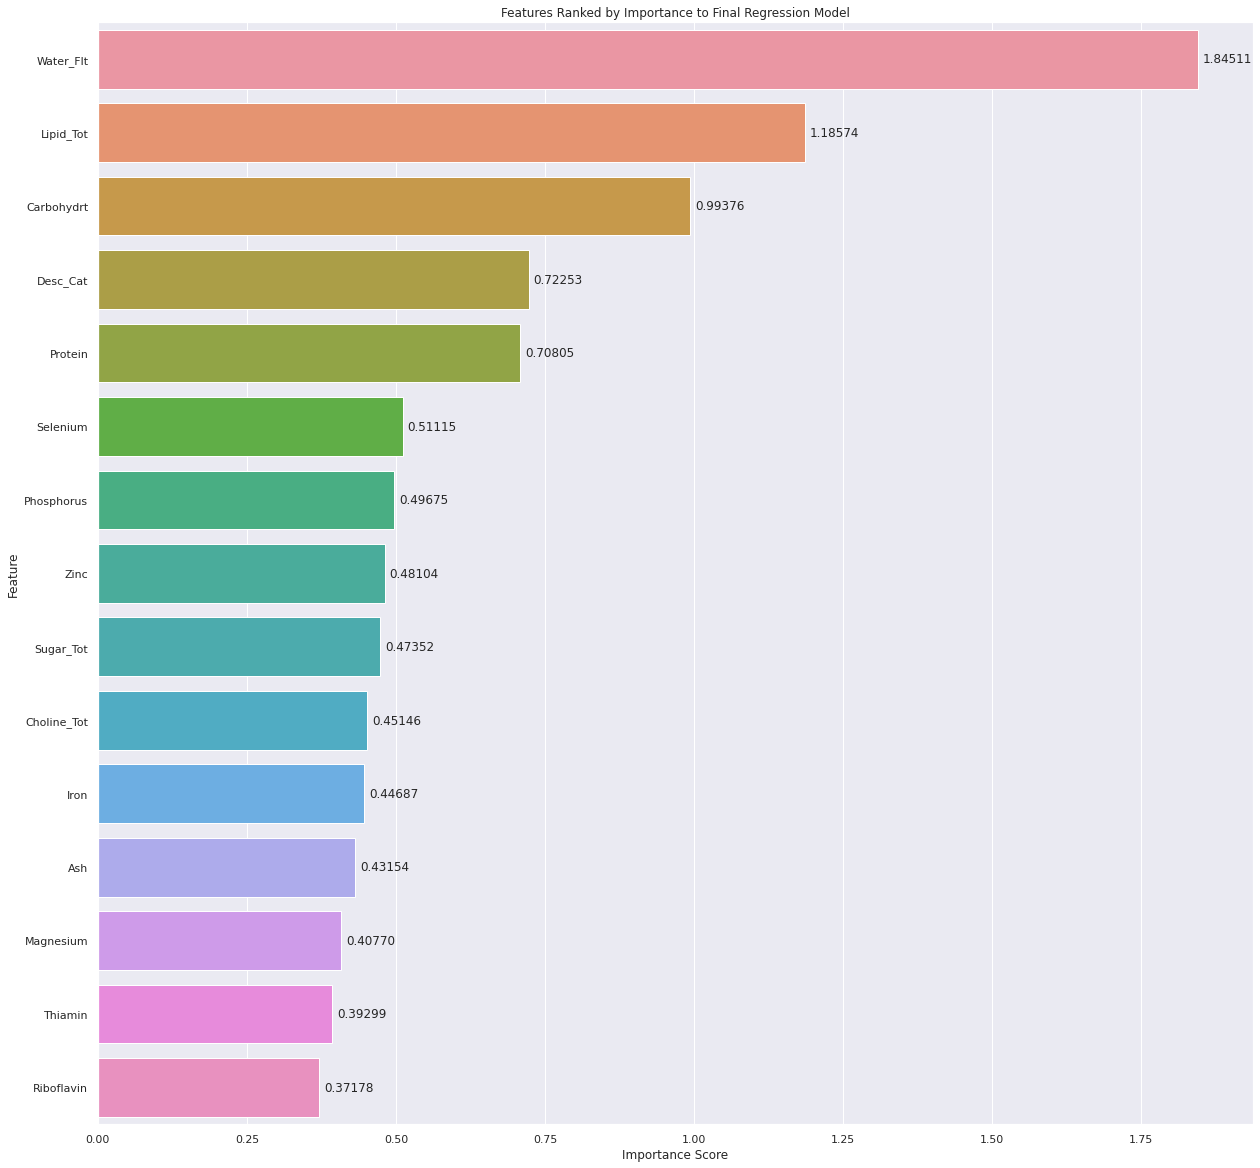

In [58]:
from sklearn import preprocessing

X_train_encoded = X_train.copy()

# Get labels for chosen columns (same as columns_chosen)
labels = [col for col in X_train]

LE = preprocessing.LabelEncoder()

X_train_encoded['Desc_Cat'] = LE.fit_transform(X_train_encoded['Desc_Cat'])

# Ravel train data
y_train_ravel = np.ravel(y_train)

# Use mutual information for feature importance
fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(X_train_encoded, y_train_ravel)

# Put importance scores into dataframe and order
df_importance = pd.DataFrame({'labels': labels, 'importance': fs.scores_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=False)

# Graph feature importances by feature
ax=sns.barplot(x='importance', y='labels', data=df_importance_sorted, orient='h')
ax.bar_label(container=ax.containers[0], fmt='%1.5f', label_type='edge', padding=5)
sns.set(rc={'figure.figsize':(20.7, 20.27)})
plt.title('Features Ranked by Importance to Final Regression Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()